**DETEKSI HATE SPEECH PADA TWITTER MENGGUNAKAN SVM**

source : https://www.kaggle.com/ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text

**1. load library**

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

**2. load dataset**

In [3]:
data = pd.read_csv('data.csv', encoding = 'latin-1')

alay_dict = pd.read_csv('new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 1: 'replacement'})

id_stopword_dict = pd.read_csv('stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})

In [4]:
data.head(5)

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [5]:
data.describe()

,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
count,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000
mean,0.422280,0.382945,0.271471,0.150809,0.060217,0.042980,0.024527,0.023236,0.284000,0.256891,0.129471,0.035918
std,0.493941,0.486123,0.444735,0.357876,0.237898,0.202819,0.154685,0.150659,0.450954,0.436935,0.335733,0.186092
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**3. check if null**

pada bagian ini berfungsi untuk mengecek apakah data tersebut terdapat missing value dalam coloumn

In [6]:
data.isna().sum()

Tweet            0
HS               0
Abusive          0
HS_Individual    0
HS_Group         0
HS_Religion      0
HS_Race          0
HS_Physical      0
HS_Gender        0
HS_Other         0
HS_Weak          0
HS_Moderate      0
HS_Strong        0
dtype: int64

In [7]:
alay_dict.head(5)

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


In [8]:
id_stopword_dict.head()

,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak


**4. plot HS**

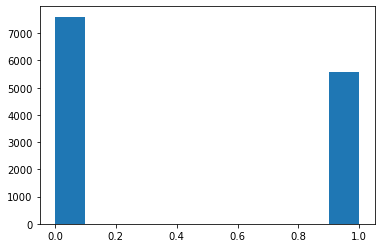

In [9]:
plt.hist(data.HS)
plt.show()

**5. menghitung postif dan negatif**

In [10]:
data.HS.value_counts()

0    7608
1    5561
Name: HS, dtype: int64

**6. preprocessing data**

In [11]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()
    
def remove_unnecessary_char(text):
    text = re.sub('\n', ' ',text) #menghapus setiap /n
    text = re.sub('rt', ' ',text) #menghapus setiap simbol retweet
    text = re.sub('user', ' ',text) #menghapus setiap username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', ' ',text) #menghapus setiap URL
    text = re.sub(' +', ' ',text) #menghapus spasi berlebih
    return text
    
def remove_nonalphanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text
    
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])
    
def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub(' +', ' ', text) #menghapus spasi berlebih
    text = text.strip()
    return text
    
def stemming(text):
    return stemmer.stem(text)

**7. preprocessing function**

In [12]:
def preprocess(text):
    text = lowercase(text) #1
    text = remove_nonalphanumeric(text) #2
    text = remove_unnecessary_char(text) #2
    text = normalize_alay(text) #3
    text = stemming(text) #4
    text = remove_stopword(text) #5
    return text

**8. apply to tweet**

In [15]:
data['Tweet'] = data['Tweet'].apply(preprocess)

In [16]:
df = data[['Tweet', 'HS']]
df.head()

,Tweet,HS
0,cowok usaha lacak perhati gue lantas remeh per...,1
1,telat tau edan sarap gue gaul cigax jifla cal ...,0
2,41 kadang pikir percaya tuhan jatuh kali kali ...,0
3,ku tau mata sipit lihat,0
4,kaum cebong kafir lihat dungu dungu haha,1


**9. prepare train and test data**

In [17]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['Tweet'], df['HS'], test_size=0.2)

In [18]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

**10. Tfidf Feature**

In [19]:
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(df['Tweet'])

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [20]:
Train_X_Tfidf.shape

(10535, 13062)

In [21]:
Train_Y.shape

(10535,)

**11. Build, train, and evaluate model**

In [22]:
SVM = SVC()
SVM.fit(Train_X_Tfidf,Train_Y)

predictions_SVM = SVM.predict(Test_X_Tfidf)

print("SVM Accuracy Score ->",accuracy_score(predictions_SVM, Test_Y)*100)
print("SVM Recall Score ->",recall_score(predictions_SVM, Test_Y)*100)
print("SVM Precision Score ->",precision_score(predictions_SVM, Test_Y)*100)
print("SVM f1 Score ->",f1_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score -> 83.37129840546697
SVM Recall Score -> 85.25441329179647
SVM Precision Score -> 73.50044762757386
SVM f1 Score -> 78.94230769230771


**12. hyperparameter tuning**

In [23]:
hyperparameters = {'kernel':('linear', 'rbf'), 'C':[1,10]}
svm = SVC()
svm_tuned = GridSearchCV(svm, hyperparameters, cv=5)

In [24]:
svm_tuned.fit(Train_X_Tfidf, Train_Y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

In [31]:
print('Best C:',svm_tuned.best_estimator_.C)
print('Best Kernel:',svm_tuned.best_estimator_.kernel)
print('Best Score:',svm_tuned.best_score_)

Best C: 10
Best Kernel: rbf
Best Score: 0.8367346938775511


**13. apply best tuning**

In [25]:
svm = SVC(C=10, kernel='rbf', degree=3, gamma='scale')
svm.fit(Train_X_Tfidf, Train_Y)

SVC(C=10)

In [28]:
predict_test = svm.predict(Test_X_Tfidf)
print("SVM Accuracy Score ->",accuracy_score(predict_test, Test_Y)*100)
print("SVM Recall Score ->",recall_score(predict_test, Test_Y)*100)
print("SVM Precision Score ->",precision_score(predict_test, Test_Y)*100)
print("SVM f1 Score ->",f1_score(predict_test, Test_Y)*100)

SVM Accuracy Score -> 83.63705391040243
SVM Recall Score -> 84.02777777777779
SVM Precision Score -> 75.82811101163833
SVM f1 Score -> 79.71764705882353


**14. confusion matrix**

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes, normalize = False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
        
        
    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print (cm)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes, title=title, ylabel='True Label', xlabel='Predicted Label')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color="white" if cm[i,j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)


Confusion matrix, without normalization
[[1356  161]
 [ 270  847]]


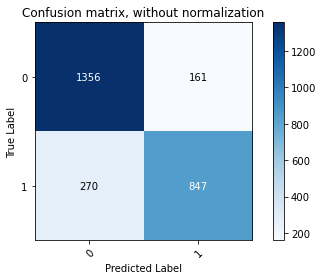

In [30]:
class_names = Test_Y
plot_confusion_matrix(Test_Y, predict_test, classes=class_names, title='Confusion matrix, without normalization')
plt.show()

**15. lets predict**

In [43]:
def classify(tweet):
    pred = svm.predict(Tfidf_vect.transform([tweet]))
    if pred == 1:
        return "Ini adalah Hate Speech"
    return "Ini bukan Hate Speech"

In [44]:
classify('film nya jelek kurang greget, banyak garing juga')

'Ini adalah Hate Speech'

In [45]:
classify('film nya jelek')

'Ini adalah Hate Speech'

In [46]:
classify('bagus banget film nya')

'Ini bukan Hate Speech'